In [1]:
import numpy as np
from matplotlib import pyplot as plt

from lava.proc.lif.process import LIF

from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.operations.operations import Weights
from lava.lib.dnf.kernels.kernels import MultiPeakKernel, SelectiveKernel
from lava.lib.dnf.operations.operations import Convolution

from lava.lib.dnf.kernels.kernels import Kernel, GaussianMixin
import typing as ty
import warnings
from abc import ABC, abstractmethod
from lava.lib.dnf.utils.convenience import to_ndarray
from lava.lib.dnf.utils.math import gauss

from lava.lib.dnf.inputs.gauss_pattern.process import GaussPattern
from lava.lib.dnf.inputs.rate_code_spike_gen.process import RateCodeSpikeGen
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import Monitor
from lava.lib.dnf.utils.plotting import raster_plot

In [2]:
class DecayKernel(GaussianMixin, Kernel):
    """
    A kernel that enables creating a selective dynamic neural field
    (local excitation, global inhibition).
    Parameters
    ----------
    amp_exc : float
        amplitude of the excitatory Gaussian of the kernel
    width_exc : list(float)
        widths of the excitatory Gaussian of the kernel
    global_inh : float
        global inhibition of the kernel; must be negative
    limit : float
        determines the size/shape of the kernel such that the weight matrix
        will have the size 2*limit*width_exc; defaults to 1
    shape : tuple(int), optional
        will return the weight with this explicit shape; if used, the limit
        argument will have no effect
    """
    def __init__(self,
                 amp_exc: float,
                 width_exc: ty.Union[float, ty.List[float]],
                 global_inh: float,
                 mean: float,
                 limit: ty.Optional[float] = 1.0,
                 shape: ty.Optional[ty.Tuple[int, ...]] = None) -> None:

        GaussianMixin.__init__(self, amp_exc, width_exc, limit, shape)
        self.mean = mean

        if global_inh > 0:
            raise ValueError("<global_inh> must be negative")
        self._global_inh = global_inh

        weights = self._compute_weights()
        Kernel.__init__(self, weights=weights, padding_value=self._global_inh)

    def _compute_weights(self) -> np.ndarray:
        local_excitation = gauss(self._shape,
                                 domain=self._compute_domain(),
                                 mean=self.mean,
                                 amplitude=self._amp_exc,
                                 stddev=self._width_exc)

        return local_excitation + self._global_inh

In [3]:
shape = (20, )
dnf = LIF(shape=shape, du=.5, dv=2047, vth=200)

kernel = DecayKernel(amp_exc=32,
                         width_exc=2.5,
                         mean=0.0,
                         global_inh=-18)
connect(dnf.s_out, dnf.a_in, ops=[Convolution(kernel)])

In [4]:
time_steps = 700

# Set up spike generator 1
gauss_pattern_1 = GaussPattern(shape=shape,
                                       amplitude=0,
                                       mean=0.0,
                                       stddev=0.25)
spike_generator_1 = RateCodeSpikeGen(shape=shape)
gauss_pattern_1.a_out.connect(spike_generator_1.a_in)

connect(spike_generator_1.s_out, dnf.a_in, [Weights(25)])

In [5]:
monitor_dnf = Monitor()
monitor_dnf.probe(target=dnf.s_out, num_steps=time_steps)

In [6]:
# Set up a run configuration
run_cfg = Loihi1SimCfg()

In [7]:
condition = RunSteps(num_steps=100)
gauss_pattern_1.run(condition=condition, run_cfg=run_cfg)
gauss_pattern_1.amplitude = 2300
condition = RunSteps(num_steps=100)
gauss_pattern_1.run(condition=condition, run_cfg=run_cfg)

[Loihi1SimCfg]: Using the first PyProcessModel PyLifModelFloat available for Process Process_0::LIF.
[Loihi1SimCfg]: Using the first PyProcessModel PyDenseModelFloat available for Process Process_1::Dense.
[Loihi1SimCfg]: Using the first PyProcessModel PyDenseModelFloat available for Process Process_6::Dense.


In [8]:
condition = RunSteps(num_steps=500)
gauss_pattern_1.amplitude = 0
gauss_pattern_1.run(condition=condition, run_cfg=run_cfg)

In [9]:
data_dnf = monitor_dnf.get_data()[dnf.name][dnf.s_out.name]

In [10]:
spike_generator_1.stop()

In [11]:
data_dnf = data_dnf.transpose()

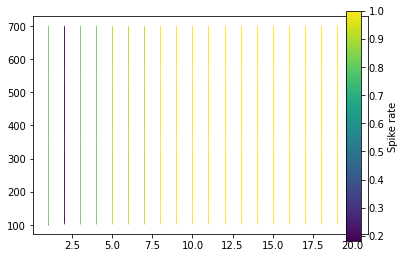

In [12]:
raster_plot(data_dnf)
cax = plt.axes([0.85, 0.1, 0.035, 0.8])
plt.colorbar(cax=cax, label="Spike rate")